In [1]:
!pip install --upgrade pip
!pip install tensorflow

ERROR: To modify pip, please run the following command:
C:\Users\vdako\anaconda3\envs\sam-model-env\python.exe -m pip install --upgrade pip


  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


In [2]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.get_logger().setLevel('ERROR')
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Tensor Flow Version: 2.13.0

Python 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
GPUs Available:  0


False

In [14]:
import pickle
dict = pickle.load(open('california-housing-dataset.pkl', 'rb'))
x_train, y_train = dict['x_train'], dict['y_train']
x_test, y_test = dict['x_test'], dict['y_test']

## Dataset Exploration


In [15]:
print(x_train.shape, y_train.shape)
print(x_train[1,:], y_train[1])

(15480, 8) (15480,)
[   2.7639        9.            8.75862069    1.72413793   66.
    2.27586207   39.04       -122.69      ] 1.125


In [16]:
features = ['MedInc', 'HouseAge' ,'AveRooms' ,'AveBedrms' ,'Population', 'AveOccup' ,'Latitude' ,'Longitude' ]

def show_dataset_min_and_max(x, y, features):
    for i in range(len(features)):
        a = x[:,i]
        print('{}; [{}, {}]'.format(features[i],min(a), max(a),))
        print('Datatype: {}'.format(a.dtype))
    print('\nMax Price: {}; Min Price: {}'.format(max(y), min(y[:])))
    

#### Non-Normalized Values


In [17]:
show_dataset_min_and_max(x_train, y_train, features)

MedInc; [0.4999, 15.0001]
Datatype: float64
HouseAge; [1.0, 52.0]
Datatype: float64
AveRooms; [0.8461538461538461, 141.9090909090909]
Datatype: float64
AveBedrms; [0.3333333333333333, 34.06666666666667]
Datatype: float64
Population; [5.0, 35682.0]
Datatype: float64
AveOccup; [0.6923076923076923, 1243.3333333333333]
Datatype: float64
Latitude; [32.54, 41.95]
Datatype: float64
Longitude; [-124.35, -114.31]
Datatype: float64

Max Price: 5.00001; Min Price: 0.14999


#### Normalized Values


In [18]:
def normalize(x):
    col_max = np.max(x, axis=0)
    col_min = np.min(x, axis=0)
    normX = np.divide(x - col_min, col_max - col_min)
    return normX

x_train_n = normalize(x_train)
y_train_n = normalize(y_train)

In [19]:
show_dataset_min_and_max(x_train_n, y_train_n, features)

MedInc; [0.0, 1.0]
Datatype: float64
HouseAge; [0.0, 1.0]
Datatype: float64
AveRooms; [0.0, 1.0]
Datatype: float64
AveBedrms; [0.0, 1.0]
Datatype: float64
Population; [0.0, 1.0]
Datatype: float64
AveOccup; [0.0, 1.0]
Datatype: float64
Latitude; [0.0, 1.0]
Datatype: float64
Longitude; [0.0, 1.0]
Datatype: float64

Max Price: 1.0; Min Price: 0.0


## Neural Network Design Experiments


In [21]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
tf.random.set_seed(1234)

In [85]:
# activation_functions = ['linear', 'relu', 'leaky_relu', 'elu', 'selu']_

In [11]:
def initialize_sequential_model(layer_sizes, activation):
    """
    Function  to initialize a sequence of layers of a given size with a given activation function.
    The input layer has been fixed to a size of 8. 
    """
    model = Sequential()
    for size in layer_sizes:
        if not model.layers : 
            model.add(Dense(size, activation=activation, input_shape=(8,))) # for first layer
        elif size == 1:
            model.add(Dense(size, activation='linear')) # for last layer
        else:
            model.add(Dense(size, activation=activation)) # for every subsequent layer
    
    return model

def visualize_and_plot(labels_predicted, ground_truth, error_functions, history):
    """ 
    Function to visualize the predicted regression values vs the actual ones
    and plot the error on each epoch in a single plot.
    """
    fig, ax = plt.subplots(1, len(error_functions) + 1, figsize=(12, 3))

    # Plot predicted vs actual values
    ax[0].plot(labels_predicted, ground_truth, '.', alpha=0.1)
    ax[0].plot(ground_truth, ground_truth)
    ax[0].set_title('Predicted vs Actual')
    ax[0].set_xlabel('Predicted values')
    ax[0].set_ylabel('Actual values')
    ax[0].legend(['pred', 'gr_tr'], loc='lower right')

    for i in range(1, len(error_functions) + 1):
        error = error_functions[i - 1];
        # Plot training history
        ax[i].plot(history.history[error])
        ax[i].plot(history.history['val_{}'.format(error)])
        ax[i].set_title(error.upper())
        ax[i].set_ylabel(error)
        ax[i].set_xlabel('Epochs')
        ax[i].legend(['train', 'val'], loc='upper right')

    plt.tight_layout()
    plt.show()

def evaluate_model_on_final_epoch(history):
    evaluation_results = {}
    for error_function in history.history.keys():
        evaluation_results[error_function.upper()] = history.history[error_function][-1]
    print(evaluation_results)
    return evaluation_results

        

In [44]:
def create_and_train_model(*args):
    layer_sizes, activation_function, epochs, optimizer, loss_function, error_functions, model_name, dataset = args
    x_train_n, y_train_n = dataset
    model = initialize_sequential_model(layer_sizes, activation_function)

    print(optimizer)

    model.compile(loss=loss_function, 
                optimizer= optimizer,
                metrics= error_functions
                )
    history = model.fit(x_train_n[:,:], #training data
                    y_train_n[:],  #Labels
                    epochs=epochs,
                    batch_size=128,
                    verbose=0,
                    validation_split = 0.2
                   )

    model.save('{}/{}'.format('saved_models', model_name))   

    return model, history



### Evaluating Loss and Activation Functions

In [13]:
import json

def evaluate_architecture(layer_sizes, activation_functions, optimizer, num_epochs, error_functions, dataset, file_name):

    x_train_n, y_train_n  = dataset 
    print("LAYER SIZES", layer_sizes)
    table = {}
    for activation_function in activation_functions:
        
        loss_function_table = {}
        print("====================================================================================")
        print('ACTIVATION FUNCTION: {}'. format(activation_function.upper()))
        for loss_function in error_functions:
            m, h= create_and_train_model(layer_sizes, activation_function, num_epochs, optimizer, loss_function, error_functions, "{}-{}".format(layer_sizes, activation_function), dataset)
            labels_predicted = m.predict(x_train_n)
            visualize_and_plot(labels_predicted, y_train_n, error_functions, h)
            metric_table = evaluate_model_on_final_epoch(h)
            loss_function_table[loss_function] = metric_table
        table[activation_function] = loss_function_table

    with open('{}.json'.format(file_name), 'w') as file:
        json.dump(table, file, indent=4)

        

LAYER SIZES [16, 32, 64, 32, 16, 8, 4, 2, 1]
ACTIVATION FUNCTION: LINEAR
===========MEAN_ABSOLUTE_ERROR===========
484/484 [==============================] - 1s 1ms/step


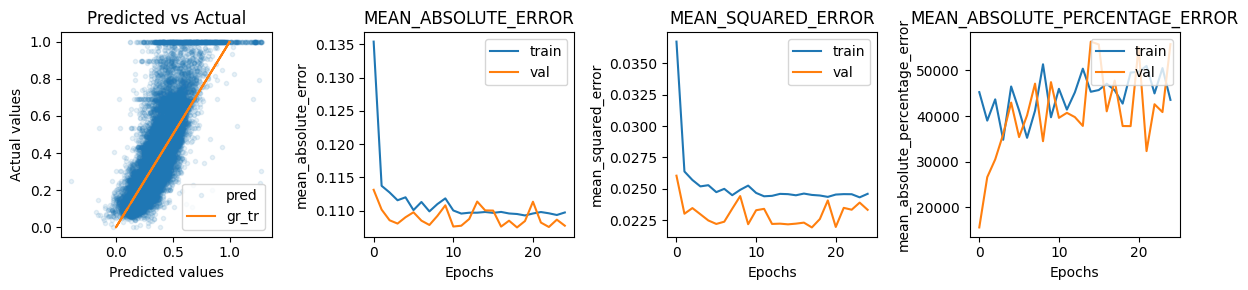

{'LOSS': 0.10970491915941238, 'MEAN_ABSOLUTE_ERROR': 0.10970491915941238, 'MEAN_SQUARED_ERROR': 0.024604270234704018, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 43528.52734375, 'VAL_LOSS': 0.10771536827087402, 'VAL_MEAN_ABSOLUTE_ERROR': 0.10771536827087402, 'VAL_MEAN_SQUARED_ERROR': 0.023330053314566612, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 55723.0546875}
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 1s 1ms/step


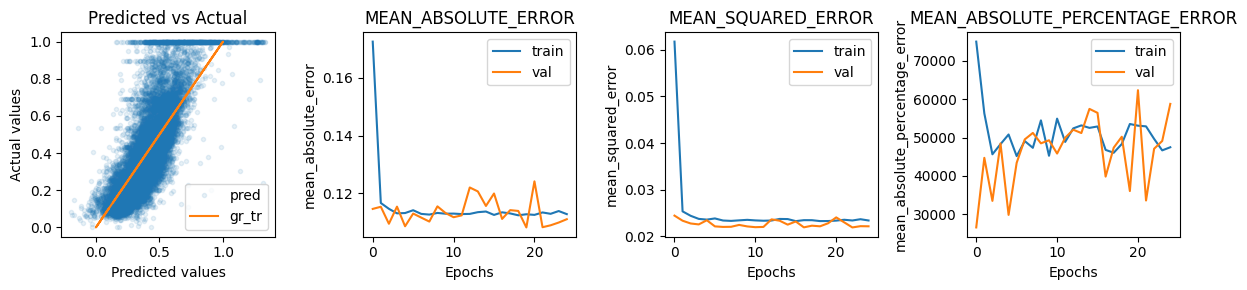

{'LOSS': 0.023389078676700592, 'MEAN_ABSOLUTE_ERROR': 0.11277851462364197, 'MEAN_SQUARED_ERROR': 0.023389078676700592, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 47484.86328125, 'VAL_LOSS': 0.022141236811876297, 'VAL_MEAN_ABSOLUTE_ERROR': 0.1110212653875351, 'VAL_MEAN_SQUARED_ERROR': 0.022141236811876297, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 58786.765625}
===========MEAN_ABSOLUTE_PERCENTAGE_ERROR===========
484/484 [==============================] - 1s 1ms/step


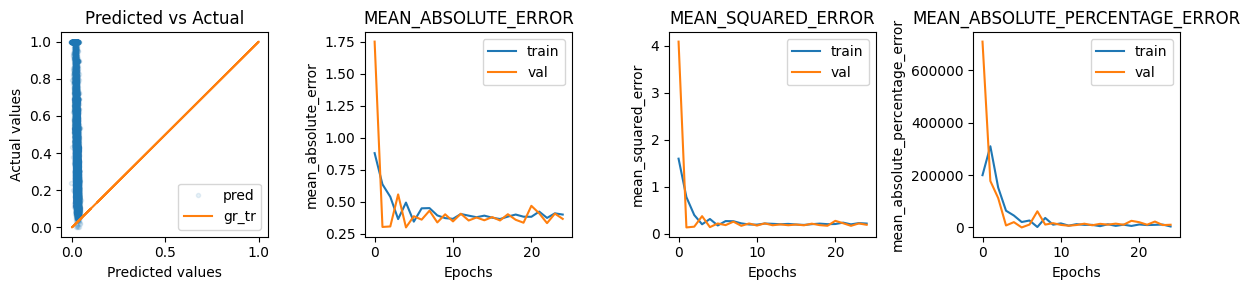

{'LOSS': 3732.953125, 'MEAN_ABSOLUTE_ERROR': 0.39876291155815125, 'MEAN_SQUARED_ERROR': 0.2171286791563034, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 3732.953125, 'VAL_LOSS': 10317.9619140625, 'VAL_MEAN_ABSOLUTE_ERROR': 0.36504054069519043, 'VAL_MEAN_SQUARED_ERROR': 0.19071875512599945, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 10317.9619140625}
ACTIVATION FUNCTION: RELU
===========MEAN_ABSOLUTE_ERROR===========
484/484 [==============================] - 1s 1ms/step


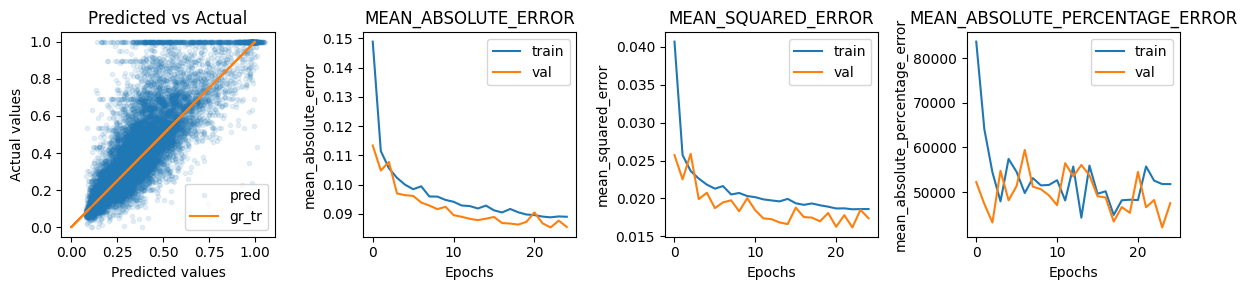

{'LOSS': 0.08897406607866287, 'MEAN_ABSOLUTE_ERROR': 0.08897406607866287, 'MEAN_SQUARED_ERROR': 0.0186022762209177, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 51809.74609375, 'VAL_LOSS': 0.08549028635025024, 'VAL_MEAN_ABSOLUTE_ERROR': 0.08549028635025024, 'VAL_MEAN_SQUARED_ERROR': 0.017387505620718002, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 47554.546875}
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 1s 956us/step


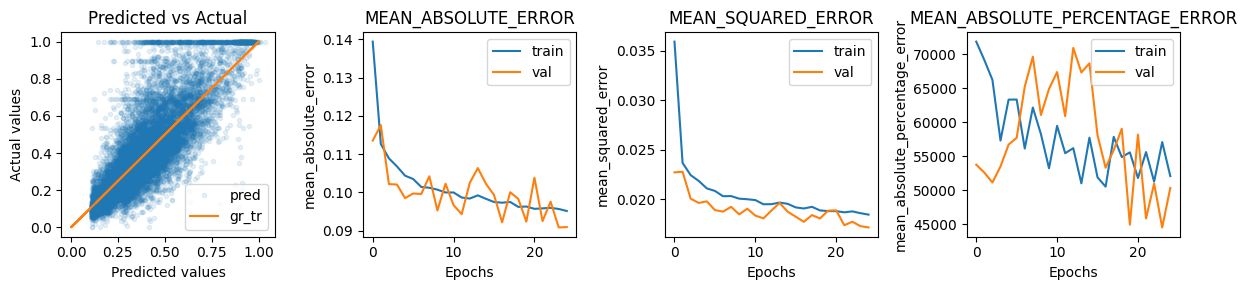

{'LOSS': 0.018450390547513962, 'MEAN_ABSOLUTE_ERROR': 0.09515148401260376, 'MEAN_SQUARED_ERROR': 0.018450390547513962, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 52083.8828125, 'VAL_LOSS': 0.01715412735939026, 'VAL_MEAN_ABSOLUTE_ERROR': 0.09094631671905518, 'VAL_MEAN_SQUARED_ERROR': 0.01715412735939026, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 50344.98828125}
===========MEAN_ABSOLUTE_PERCENTAGE_ERROR===========
484/484 [==============================] - 1s 1ms/step


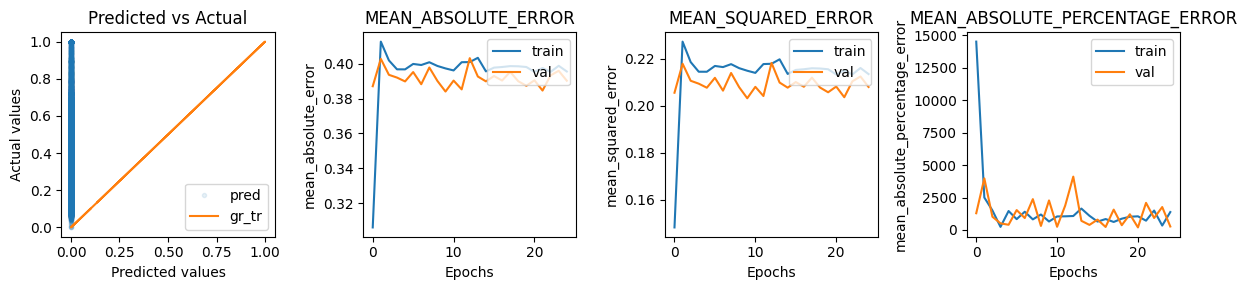

{'LOSS': 1380.50244140625, 'MEAN_ABSOLUTE_ERROR': 0.39547961950302124, 'MEAN_SQUARED_ERROR': 0.2135780155658722, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 1380.50244140625, 'VAL_LOSS': 269.2281494140625, 'VAL_MEAN_ABSOLUTE_ERROR': 0.3902021646499634, 'VAL_MEAN_SQUARED_ERROR': 0.20808111131191254, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 269.2281494140625}
ACTIVATION FUNCTION: ELU
===========MEAN_ABSOLUTE_ERROR===========
484/484 [==============================] - 0s 894us/step


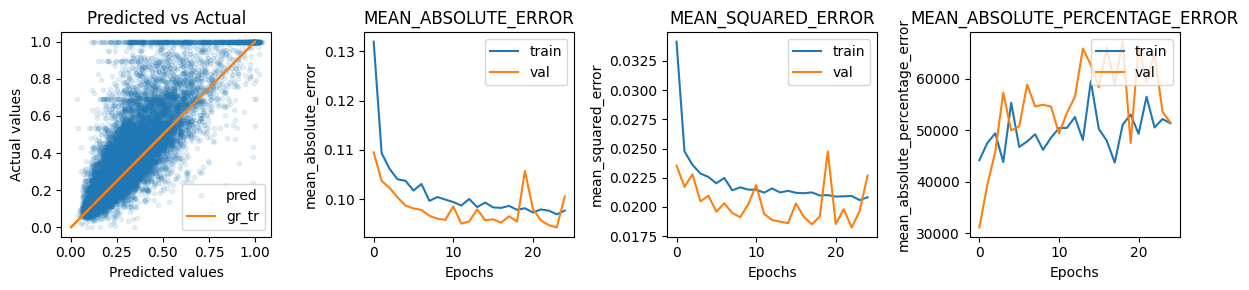

{'LOSS': 0.0977342426776886, 'MEAN_ABSOLUTE_ERROR': 0.0977342426776886, 'MEAN_SQUARED_ERROR': 0.020827606320381165, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 51378.3515625, 'VAL_LOSS': 0.10058524459600449, 'VAL_MEAN_ABSOLUTE_ERROR': 0.10058524459600449, 'VAL_MEAN_SQUARED_ERROR': 0.022686723619699478, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 51510.99609375}
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 1s 935us/step


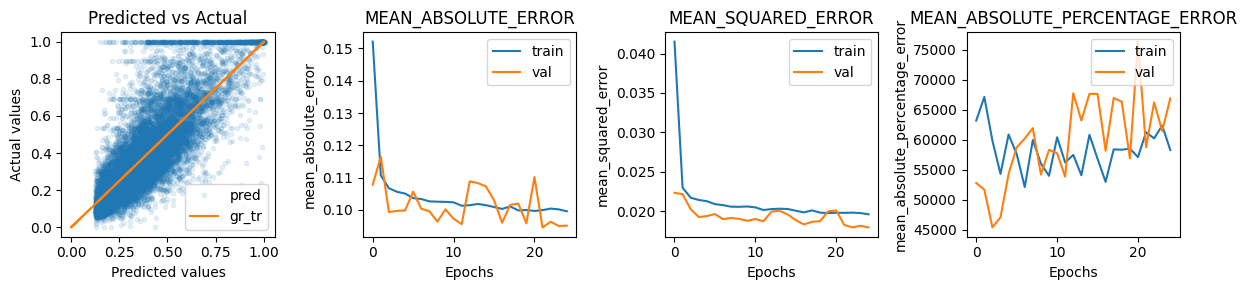

{'LOSS': 0.019608311355113983, 'MEAN_ABSOLUTE_ERROR': 0.09954491257667542, 'MEAN_SQUARED_ERROR': 0.019608311355113983, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 58273.0078125, 'VAL_LOSS': 0.01793999969959259, 'VAL_MEAN_ABSOLUTE_ERROR': 0.09510535001754761, 'VAL_MEAN_SQUARED_ERROR': 0.01793999969959259, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 66894.546875}
===========MEAN_ABSOLUTE_PERCENTAGE_ERROR===========
484/484 [==============================] - 1s 1ms/step


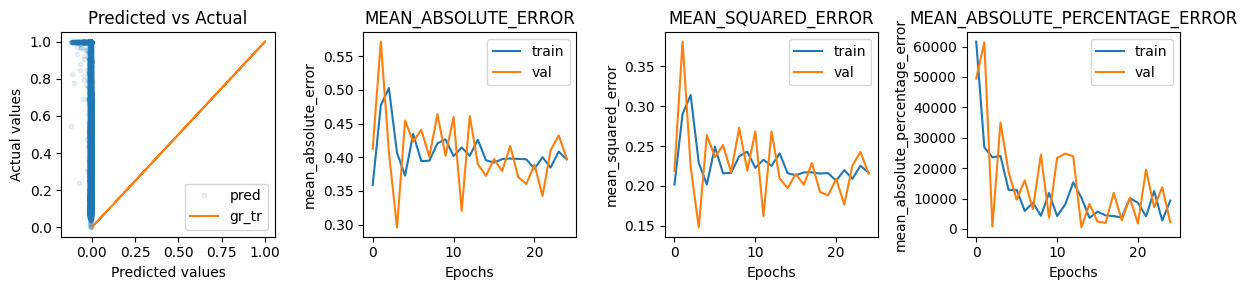

{'LOSS': 9330.1708984375, 'MEAN_ABSOLUTE_ERROR': 0.39677953720092773, 'MEAN_SQUARED_ERROR': 0.21647179126739502, 'MEAN_ABSOLUTE_PERCENTAGE_ERROR': 9330.1708984375, 'VAL_LOSS': 2160.981201171875, 'VAL_MEAN_ABSOLUTE_ERROR': 0.39804261922836304, 'VAL_MEAN_SQUARED_ERROR': 0.21516503393650055, 'VAL_MEAN_ABSOLUTE_PERCENTAGE_ERROR': 2160.981201171875}


In [165]:
l = [16, 32, 64, 32, 16, 8, 4, 2, 1]
optimizer = tf.keras.optimizers.legacy.Adam()
error_functions = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error']
activation_functions = ['linear', 'relu', 'elu']
evaluate_architecture(l, activation_functions, optimizer, 25, error_functions, [x_train_n, y_train_n], 'experiment_activation_loss')

### Evaluating Neural Network Layer Structures

In [168]:
activation_function = ['relu']
error_functions = ['mean_squared_error']
optimizer = tf.keras.optimizers.legacy.Adam()

In [155]:
l1 = [16, 32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
l2 = [16, 32, 16, 8, 1]
l3 = [16, 32, 64, 32, 16, 8, 4, 2, 1]
l4 = [16, 32, 64, 128, 256, 128, 64, 32, 16, 8, 4, 1]

LAYER SIZES [16, 32, 64, 128, 256, 512, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
ACTIVATION FUNCTION: RELU
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 2s 4ms/step


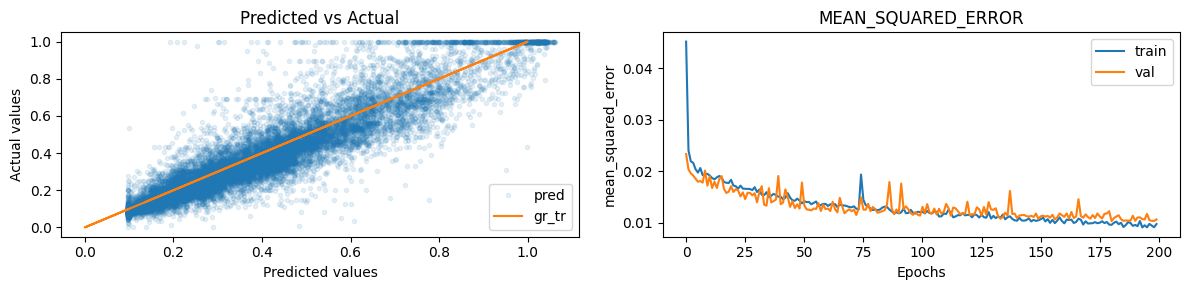

{'LOSS': 0.009708911180496216, 'MEAN_SQUARED_ERROR': 0.009708911180496216, 'VAL_LOSS': 0.010607288219034672, 'VAL_MEAN_SQUARED_ERROR': 0.010607288219034672}


In [161]:
evaluate_architecture(l1, activation_function, 200, optimizer, error_functions, [x_train_n, y_train_n], 'experiment_size_{}'.format(l1))

LAYER SIZES [16, 32, 16, 8, 1]
ACTIVATION FUNCTION: RELU
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 0s 876us/step


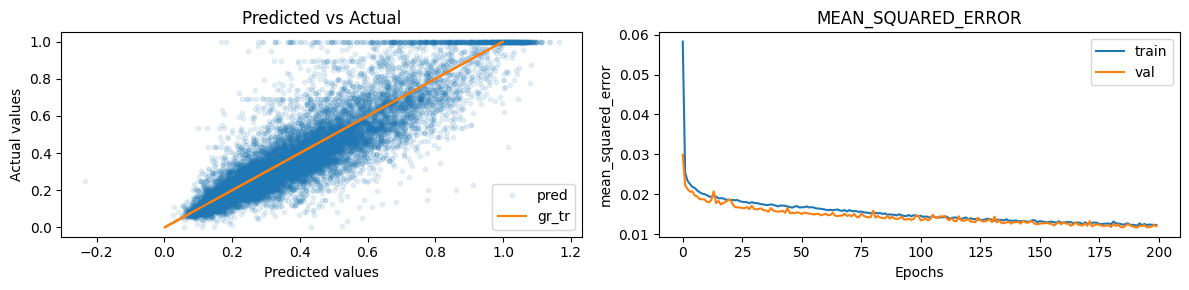

{'LOSS': 0.012289862148463726, 'MEAN_SQUARED_ERROR': 0.012289862148463726, 'VAL_LOSS': 0.011977817863225937, 'VAL_MEAN_SQUARED_ERROR': 0.011977817863225937}


In [160]:
evaluate_architecture(l2, activation_function, optimizer, 200, error_functions, [x_train_n, y_train_n], 'experiment_size_{}'.format(l2))

LAYER SIZES [16, 32, 64, 32, 16, 8, 4, 2, 1]
ACTIVATION FUNCTION: RELU
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 0s 864us/step


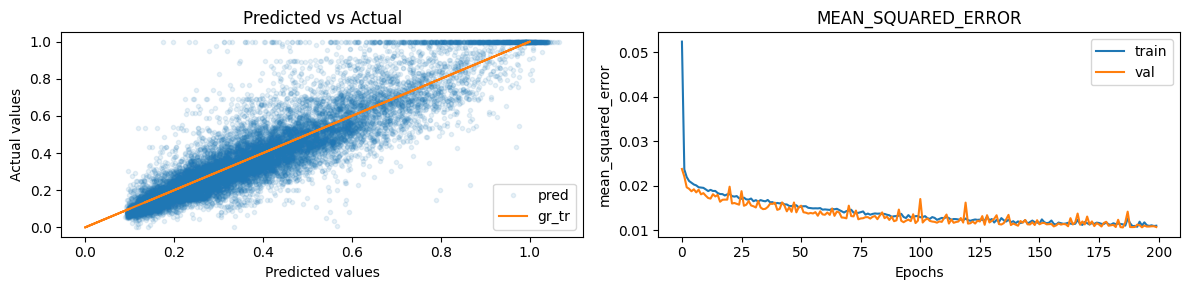

{'LOSS': 0.01098552718758583, 'MEAN_SQUARED_ERROR': 0.01098552718758583, 'VAL_LOSS': 0.01069102343171835, 'VAL_MEAN_SQUARED_ERROR': 0.01069102343171835}


In [162]:
evaluate_architecture(l3, activation_function, optimizer, 200, error_functions, [x_train_n, y_train_n], 'experiment_size_{}'.format(l3))

LAYER SIZES [16, 32, 64, 128, 256, 128, 64, 32, 16, 8, 4, 1]
ACTIVATION FUNCTION: RELU
===========MEAN_SQUARED_ERROR===========
484/484 [==============================] - 1s 1ms/step


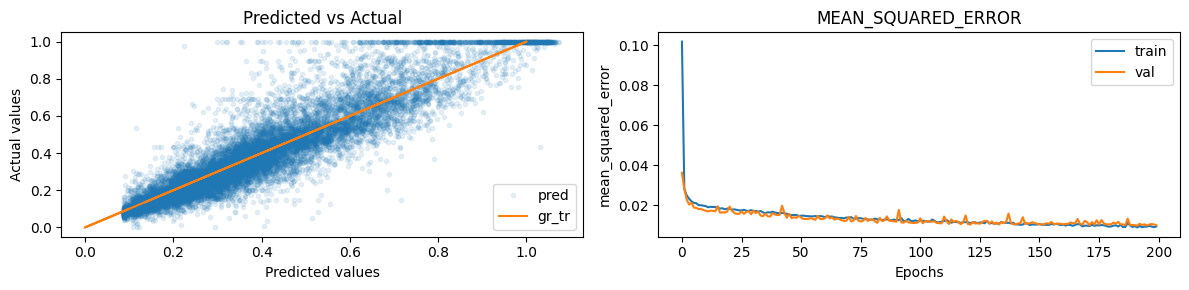

{'LOSS': 0.00941777229309082, 'MEAN_SQUARED_ERROR': 0.00941777229309082, 'VAL_LOSS': 0.010025830939412117, 'VAL_MEAN_SQUARED_ERROR': 0.010025830939412117}


In [170]:
evaluate_architecture(l4, activation_functions, 200, error_functions, [x_train_n, y_train_n], 'experiment_size_{}'.format(l4))

### Optimizer Evaluation

In [ ]:
initial_learning_rates = [0.1, 0.01, 0.001]
decay_rates = [1, 0.96, 0.1]
num_epochs = 100

In [26]:
num_samples = len(x_train_n) * 0.8
batch_size = 128
number_of_steps_per_epoch = num_samples / batch_size
print('Number of steps per epoch', number_of_steps_per_epoch)

In [52]:
import json
from tensorflow.keras.optimizers import Adam, SGD

def evaluate_optimizer_and_learning_rate(initial_learning_rates, decay_rates, optimizer_name, num_epochs, dataset, file_name):

    x_train_n, y_train_n  = dataset 
    layer_sizes = [16, 32, 64, 128, 256, 128, 64, 32, 16, 8, 4, 1]
    activation_function = 'relu'
    loss_function = 'mean_squared_error'
    table = {}

    for initial_learning_rate in initial_learning_rates:
        learning_rate_table = {}
        for decay_rate in decay_rates:
            print('INITIAL LEARNING RATE: ', initial_learning_rate)
            print('DECAY RATE: ', decay_rate)
            lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=10000,
                decay_rate=decay_rate)
            optimizer = None 
            if optimizer_name == 'Adam':
                optimizer = Adam(learning_rate=lr_schedule)
            elif optimizer_name == 'SGD':
                optimizer = SGD(learning_rate=lr_schedule)
            elif optimizer_name == 'SGDM_Small':
                optimizer = SGD(learning_rate=lr_schedule, momentum=0.9)
            elif optimizer_name == 'SGDM_Large':
                optimizer = SGD(learning_rate=lr_schedule, momentum=0.99)
            else:
                raise TypeError("WE SHOULDN'T END HERE")

            m, h= create_and_train_model(layer_sizes, activation_function, num_epochs, optimizer, loss_function, error_functions, "{}-{}".format(layer_sizes, activation_function), dataset)
            labels_predicted = m.predict(x_train_n)
            visualize_and_plot(labels_predicted, y_train_n, error_functions, h)
            metric_table = evaluate_model_on_final_epoch(h)

            learning_rate_table[decay_rate] = metric_table
        table[initial_learning_rate] = learning_rate_table
        


    with open('{}.json'.format(file_name), 'w') as file:
        json.dump(table, file, indent=4)

        

INITIAL LEARNING RATE:  0.1
DECAY RATE:  1
484/484 [==============================] - 1s 2ms/step


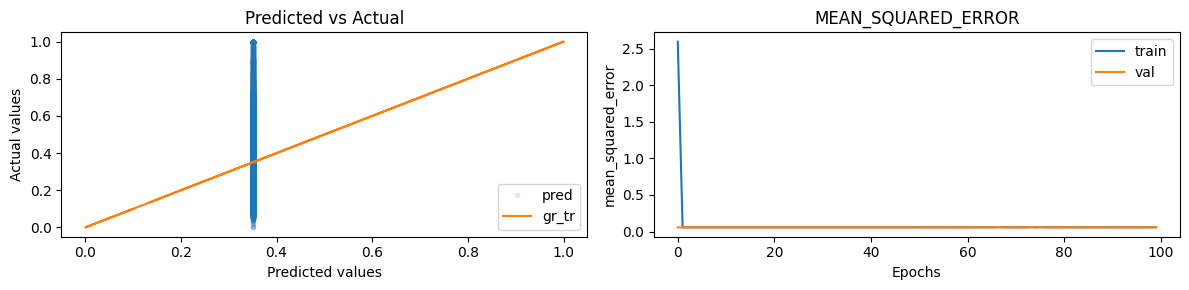

{'LOSS': 0.05854439735412598, 'MEAN_SQUARED_ERROR': 0.05854439735412598, 'VAL_LOSS': 0.05741604045033455, 'VAL_MEAN_SQUARED_ERROR': 0.05741604045033455}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


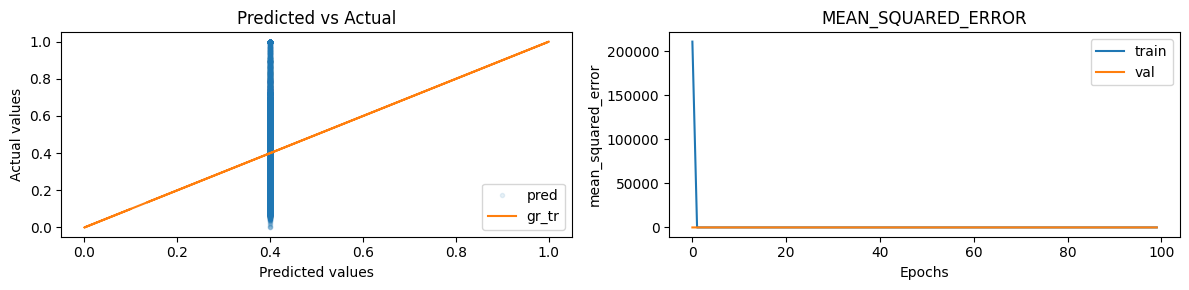

{'LOSS': 0.057197194546461105, 'MEAN_SQUARED_ERROR': 0.057197194546461105, 'VAL_LOSS': 0.05591897293925285, 'VAL_MEAN_SQUARED_ERROR': 0.05591897293925285}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


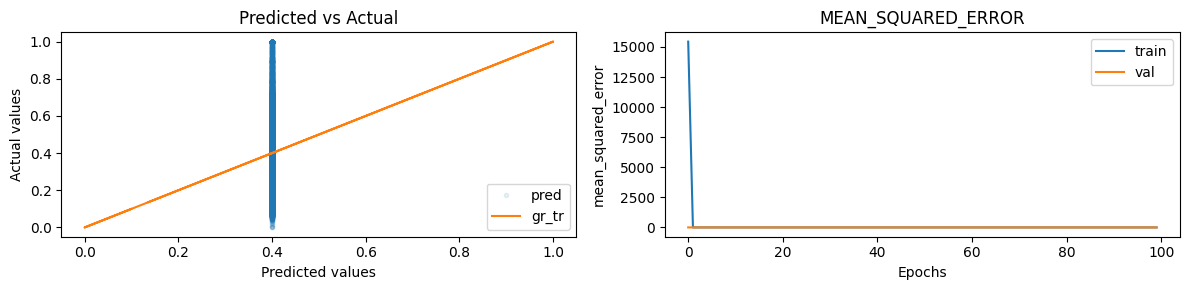

{'LOSS': 0.057186152786016464, 'MEAN_SQUARED_ERROR': 0.057186152786016464, 'VAL_LOSS': 0.05590837448835373, 'VAL_MEAN_SQUARED_ERROR': 0.05590837448835373}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


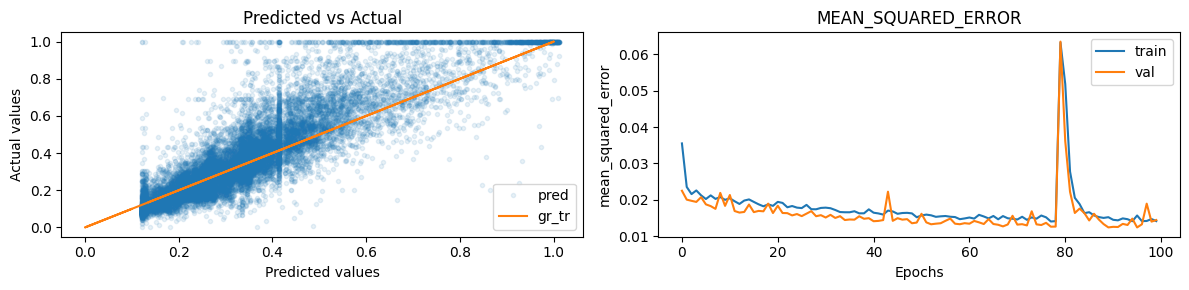

{'LOSS': 0.014132823795080185, 'MEAN_SQUARED_ERROR': 0.014132823795080185, 'VAL_LOSS': 0.014431365765631199, 'VAL_MEAN_SQUARED_ERROR': 0.014431365765631199}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


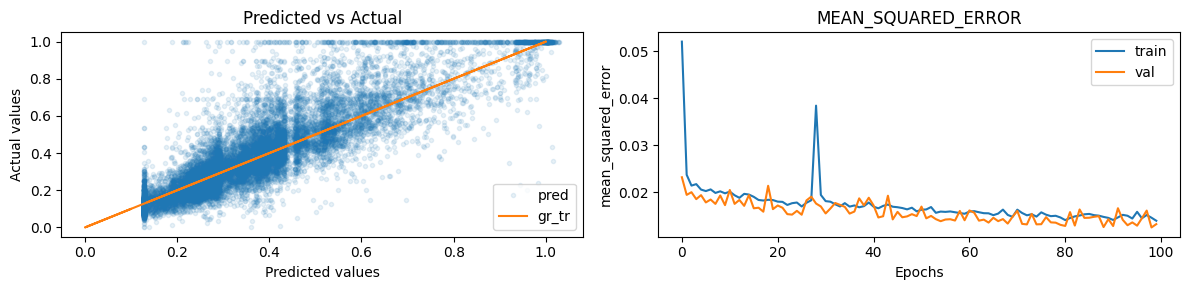

{'LOSS': 0.013939930126070976, 'MEAN_SQUARED_ERROR': 0.013939930126070976, 'VAL_LOSS': 0.013216422870755196, 'VAL_MEAN_SQUARED_ERROR': 0.013216422870755196}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


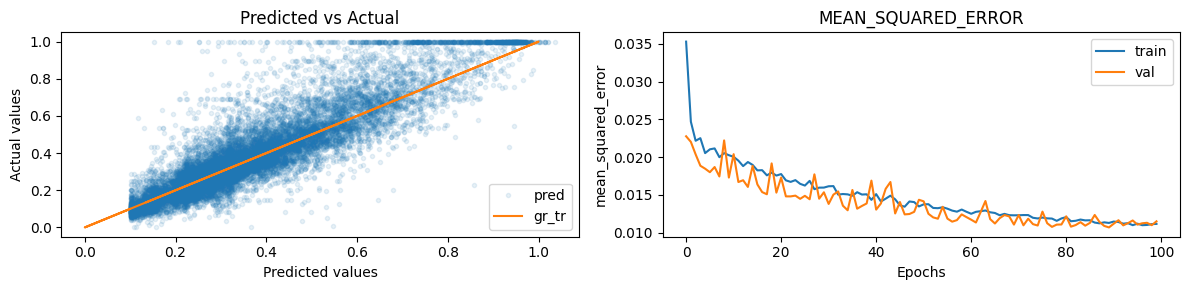

{'LOSS': 0.011160866357386112, 'MEAN_SQUARED_ERROR': 0.011160866357386112, 'VAL_LOSS': 0.01149924099445343, 'VAL_MEAN_SQUARED_ERROR': 0.01149924099445343}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


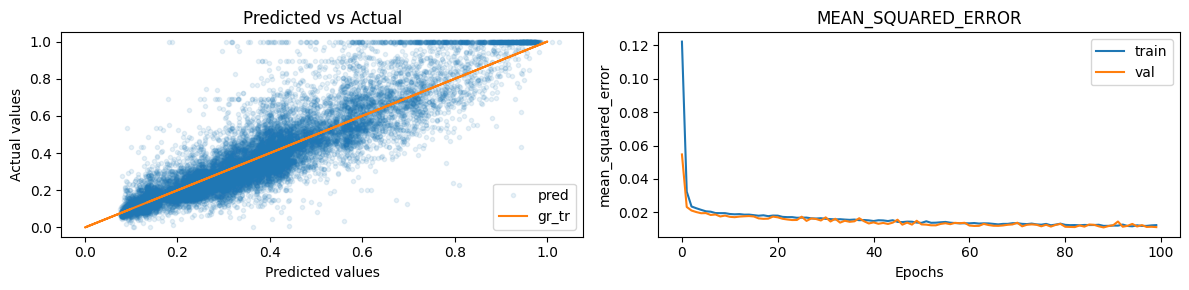

{'LOSS': 0.012347731739282608, 'MEAN_SQUARED_ERROR': 0.012347731739282608, 'VAL_LOSS': 0.011153753846883774, 'VAL_MEAN_SQUARED_ERROR': 0.011153753846883774}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


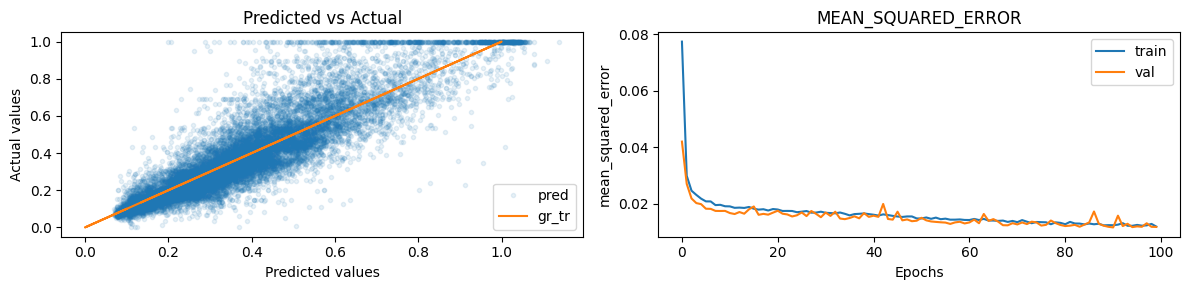

{'LOSS': 0.011961860582232475, 'MEAN_SQUARED_ERROR': 0.011961860582232475, 'VAL_LOSS': 0.011842276901006699, 'VAL_MEAN_SQUARED_ERROR': 0.011842276901006699}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


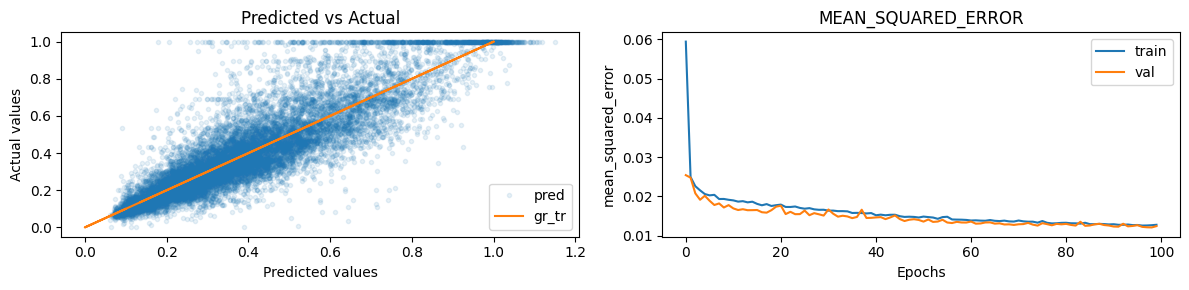

{'LOSS': 0.012797627598047256, 'MEAN_SQUARED_ERROR': 0.012797627598047256, 'VAL_LOSS': 0.012459042482078075, 'VAL_MEAN_SQUARED_ERROR': 0.012459042482078075}


In [54]:
evaluate_optimizer_and_learning_rate(initial_learning_rates, decay_rates, 'Adam', 100, [x_train_n, y_train_n], 'adam_learning_rate_table')

INITIAL LEARNING RATE:  0.1
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


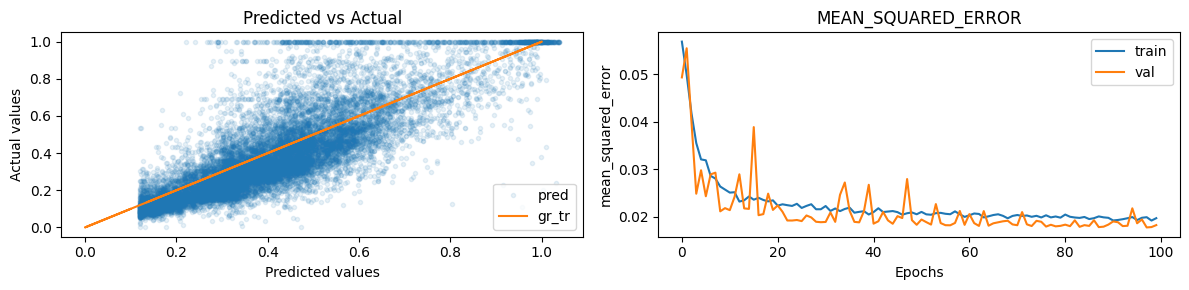

{'LOSS': 0.019725019112229347, 'MEAN_SQUARED_ERROR': 0.019725019112229347, 'VAL_LOSS': 0.018265385180711746, 'VAL_MEAN_SQUARED_ERROR': 0.018265385180711746}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


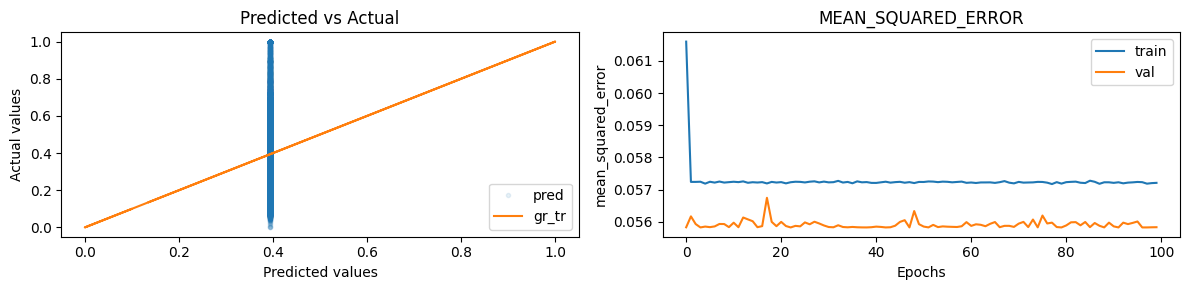

{'LOSS': 0.057209715247154236, 'MEAN_SQUARED_ERROR': 0.057209715247154236, 'VAL_LOSS': 0.0558304637670517, 'VAL_MEAN_SQUARED_ERROR': 0.0558304637670517}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


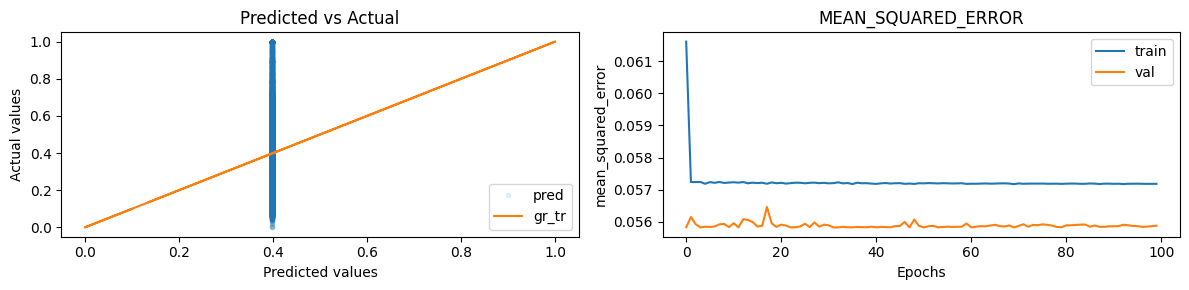

{'LOSS': 0.05718116834759712, 'MEAN_SQUARED_ERROR': 0.05718116834759712, 'VAL_LOSS': 0.05587700009346008, 'VAL_MEAN_SQUARED_ERROR': 0.05587700009346008}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


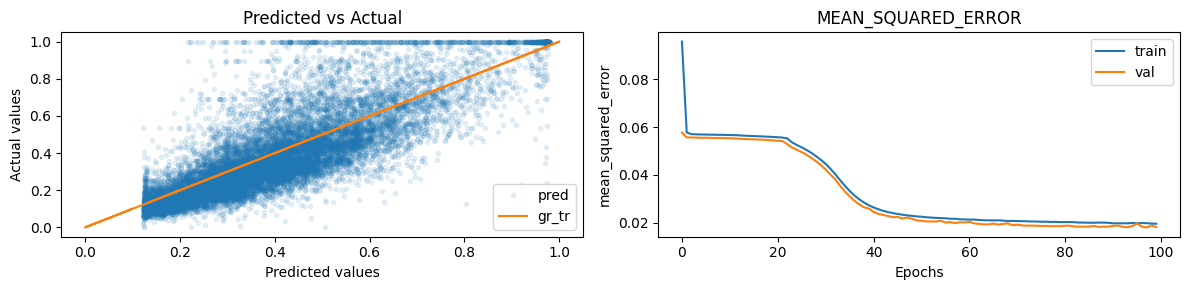

{'LOSS': 0.019577428698539734, 'MEAN_SQUARED_ERROR': 0.019577428698539734, 'VAL_LOSS': 0.01815839111804962, 'VAL_MEAN_SQUARED_ERROR': 0.01815839111804962}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


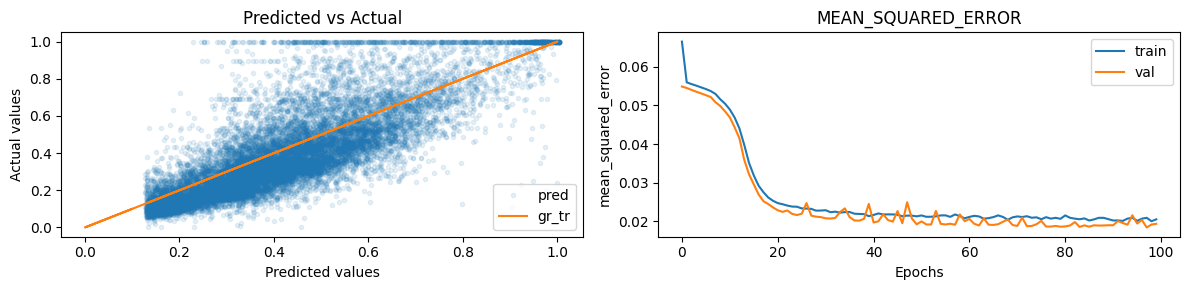

{'LOSS': 0.020520005375146866, 'MEAN_SQUARED_ERROR': 0.020520005375146866, 'VAL_LOSS': 0.01936202123761177, 'VAL_MEAN_SQUARED_ERROR': 0.01936202123761177}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


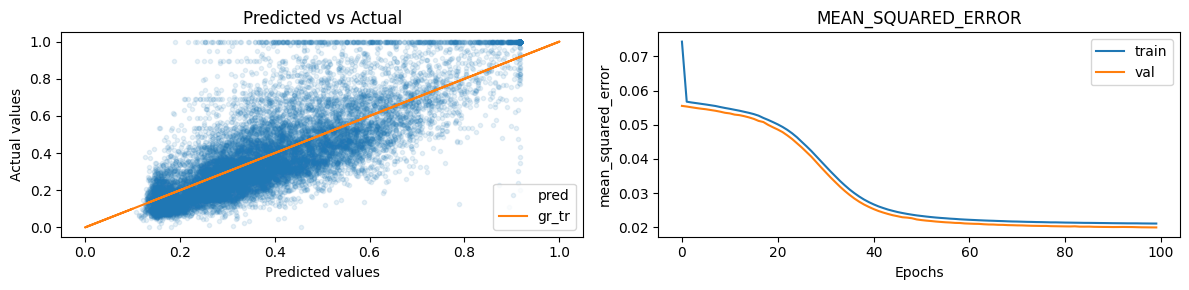

{'LOSS': 0.021144423633813858, 'MEAN_SQUARED_ERROR': 0.021144423633813858, 'VAL_LOSS': 0.020011229440569878, 'VAL_MEAN_SQUARED_ERROR': 0.020011229440569878}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


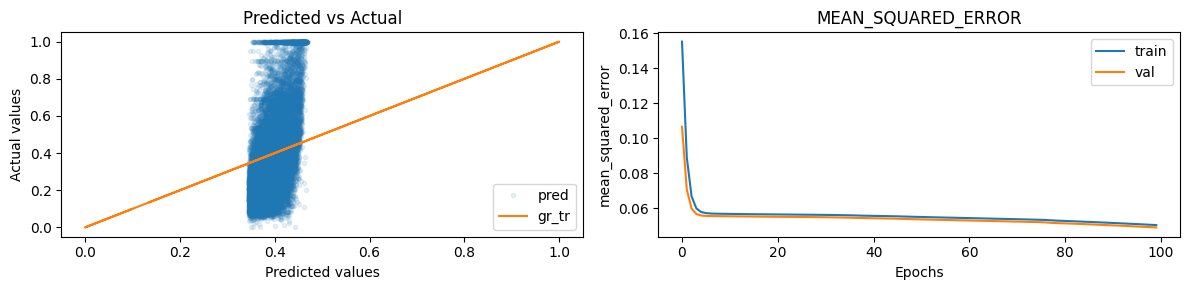

{'LOSS': 0.050420135259628296, 'MEAN_SQUARED_ERROR': 0.050420135259628296, 'VAL_LOSS': 0.04907706007361412, 'VAL_MEAN_SQUARED_ERROR': 0.04907706007361412}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


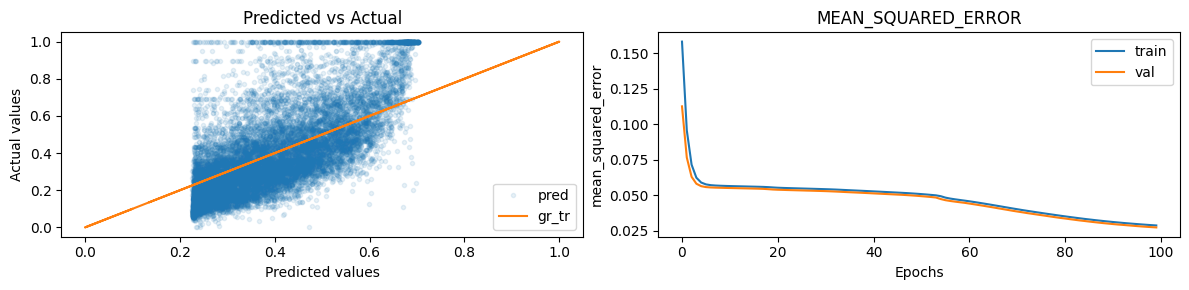

{'LOSS': 0.028569061309099197, 'MEAN_SQUARED_ERROR': 0.028569061309099197, 'VAL_LOSS': 0.02717362716794014, 'VAL_MEAN_SQUARED_ERROR': 0.02717362716794014}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


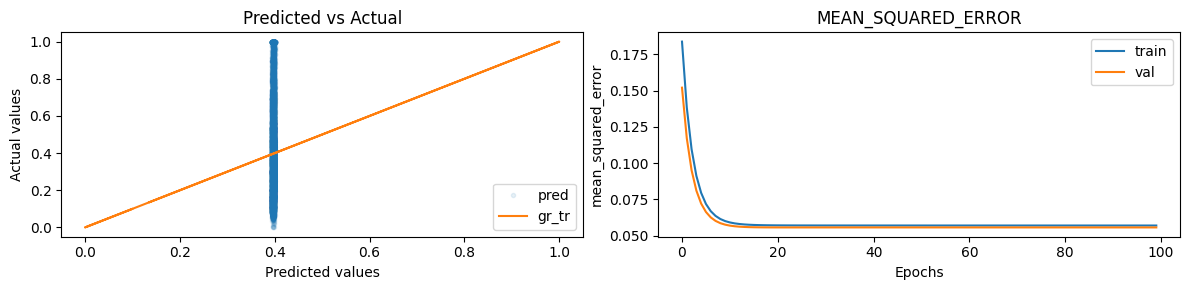

{'LOSS': 0.05707798898220062, 'MEAN_SQUARED_ERROR': 0.05707798898220062, 'VAL_LOSS': 0.055760785937309265, 'VAL_MEAN_SQUARED_ERROR': 0.055760785937309265}


In [55]:
evaluate_optimizer_and_learning_rate(initial_learning_rates, decay_rates, 'SGD', 100, [x_train_n, y_train_n], 'sgd_learning_rate_table')

INITIAL LEARNING RATE:  0.1
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


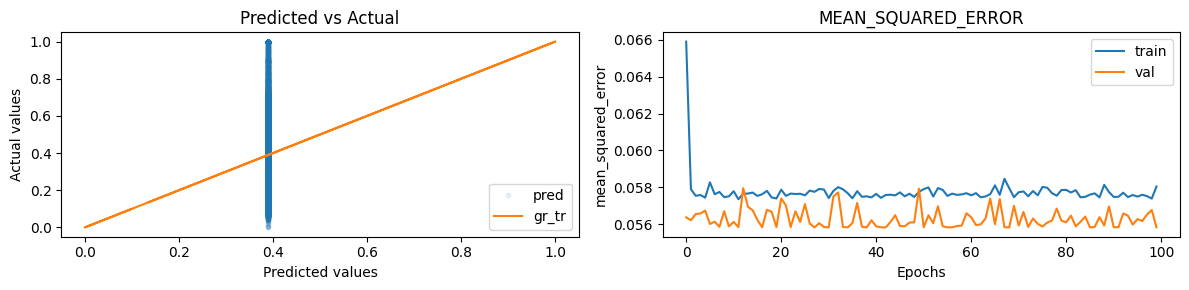

{'LOSS': 0.05804384872317314, 'MEAN_SQUARED_ERROR': 0.05804384872317314, 'VAL_LOSS': 0.05582795664668083, 'VAL_MEAN_SQUARED_ERROR': 0.05582795664668083}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.96
484/484 [==============================] - 1s 2ms/step


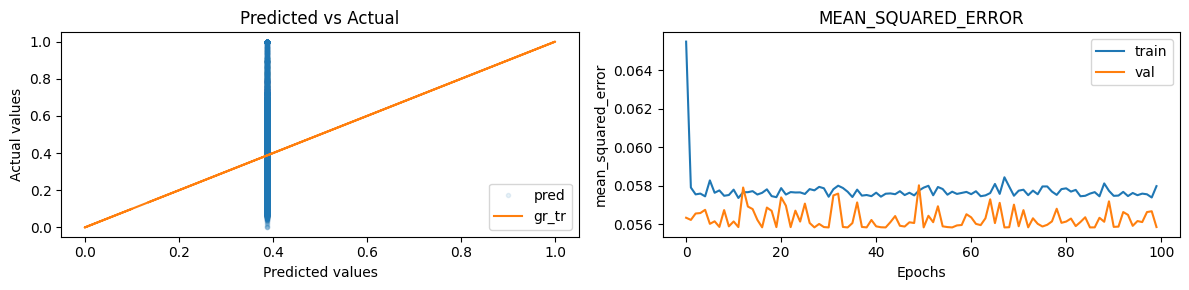

{'LOSS': 0.05796853452920914, 'MEAN_SQUARED_ERROR': 0.05796853452920914, 'VAL_LOSS': 0.05584297701716423, 'VAL_MEAN_SQUARED_ERROR': 0.05584297701716423}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.1
484/484 [==============================] - 1s 2ms/step


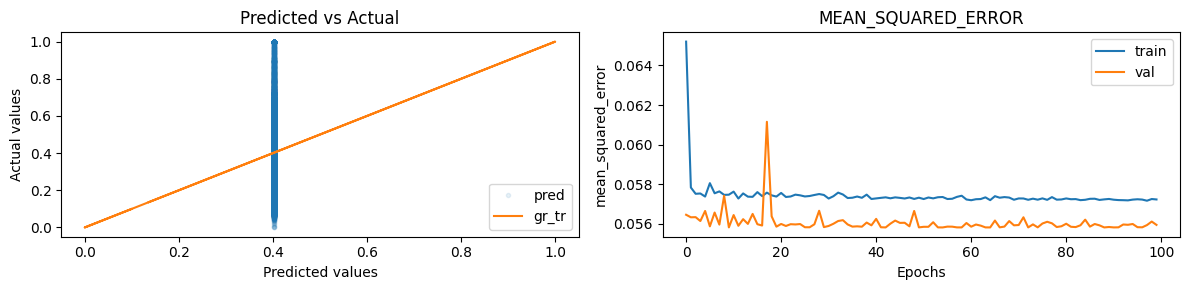

{'LOSS': 0.057235728949308395, 'MEAN_SQUARED_ERROR': 0.057235728949308395, 'VAL_LOSS': 0.05595214664936066, 'VAL_MEAN_SQUARED_ERROR': 0.05595214664936066}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


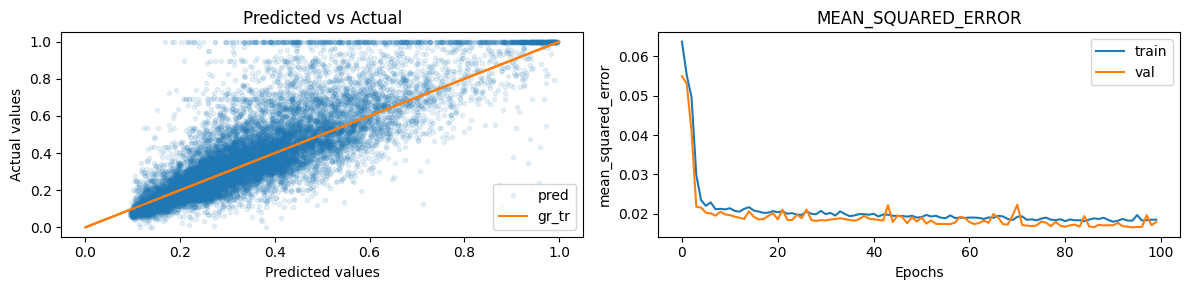

{'LOSS': 0.018483050167560577, 'MEAN_SQUARED_ERROR': 0.018483050167560577, 'VAL_LOSS': 0.01791023276746273, 'VAL_MEAN_SQUARED_ERROR': 0.01791023276746273}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


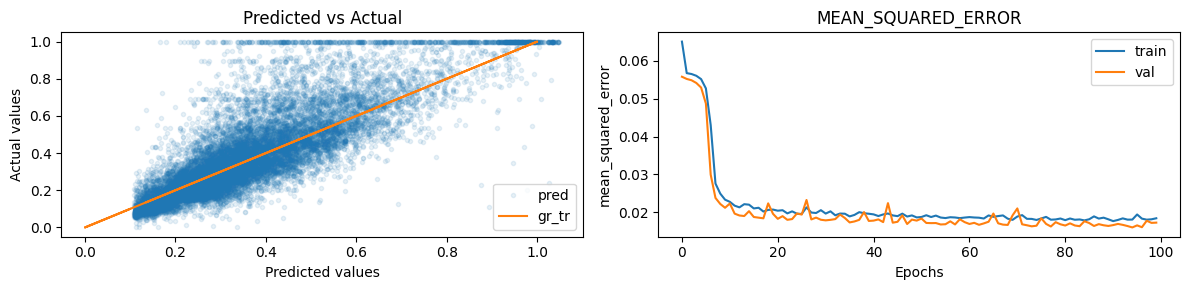

{'LOSS': 0.018396390601992607, 'MEAN_SQUARED_ERROR': 0.018396390601992607, 'VAL_LOSS': 0.01724572665989399, 'VAL_MEAN_SQUARED_ERROR': 0.01724572665989399}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


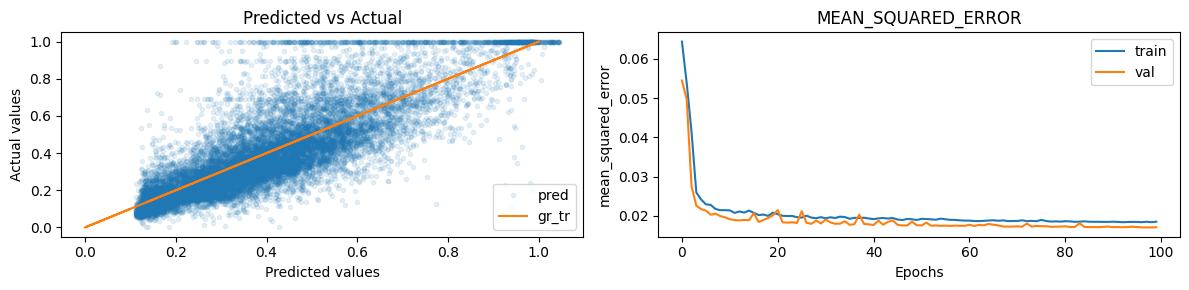

{'LOSS': 0.01851201429963112, 'MEAN_SQUARED_ERROR': 0.01851201429963112, 'VAL_LOSS': 0.01708022877573967, 'VAL_MEAN_SQUARED_ERROR': 0.01708022877573967}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


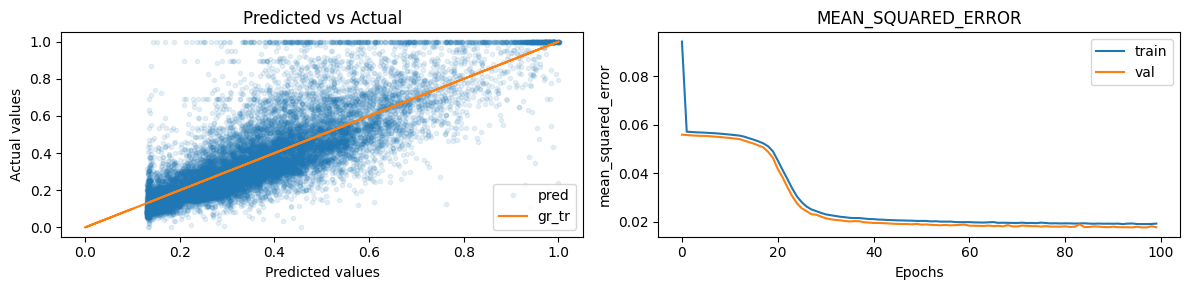

{'LOSS': 0.01926020160317421, 'MEAN_SQUARED_ERROR': 0.01926020160317421, 'VAL_LOSS': 0.017757238820195198, 'VAL_MEAN_SQUARED_ERROR': 0.017757238820195198}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.96
484/484 [==============================] - 2s 3ms/step


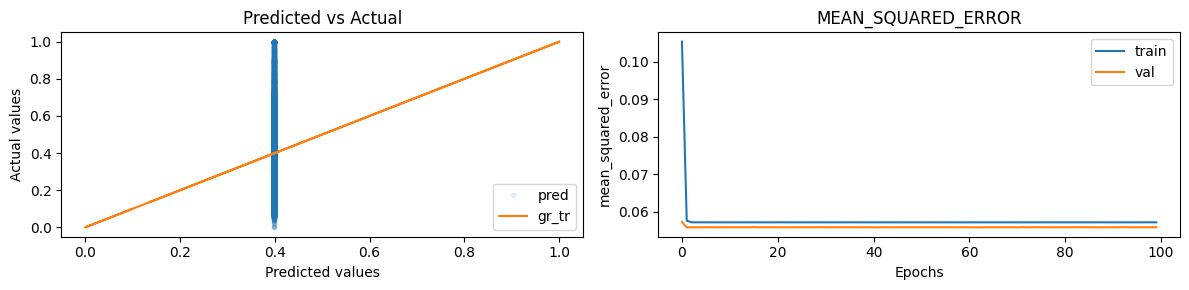

{'LOSS': 0.05718223378062248, 'MEAN_SQUARED_ERROR': 0.05718223378062248, 'VAL_LOSS': 0.05588335171341896, 'VAL_MEAN_SQUARED_ERROR': 0.05588335171341896}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.1
484/484 [==============================] - 1s 2ms/step


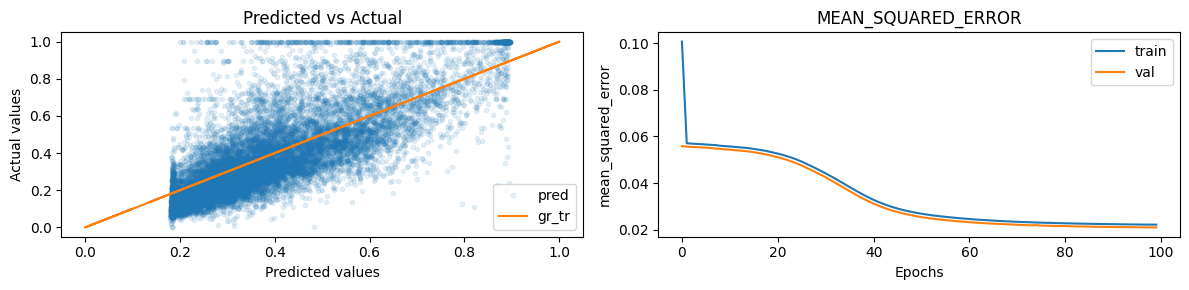

{'LOSS': 0.02208835817873478, 'MEAN_SQUARED_ERROR': 0.02208835817873478, 'VAL_LOSS': 0.020911332219839096, 'VAL_MEAN_SQUARED_ERROR': 0.020911332219839096}


In [57]:
evaluate_optimizer_and_learning_rate(initial_learning_rates, decay_rates, 'SGDM_Small', 100, [x_train_n, y_train_n], 'sgd_small_learning_rate_table')

INITIAL LEARNING RATE:  0.1
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


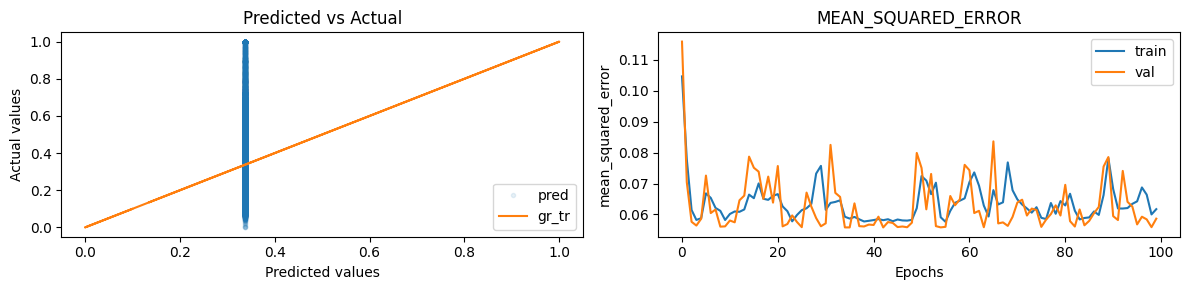

{'LOSS': 0.06172465160489082, 'MEAN_SQUARED_ERROR': 0.06172465160489082, 'VAL_LOSS': 0.05864696204662323, 'VAL_MEAN_SQUARED_ERROR': 0.05864696204662323}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


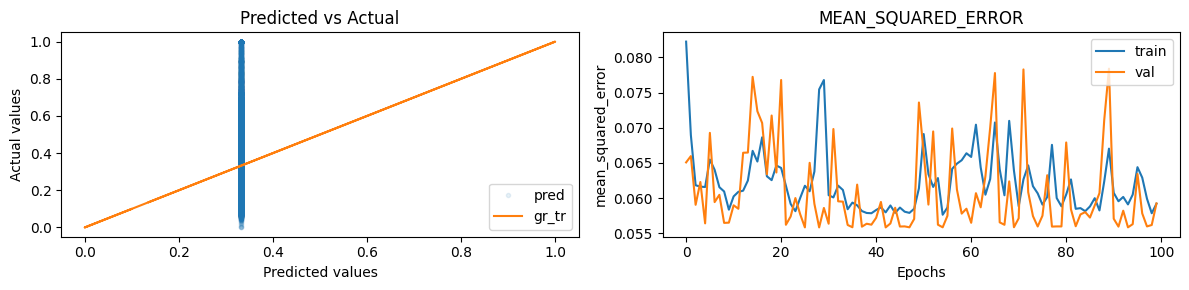

{'LOSS': 0.05919898673892021, 'MEAN_SQUARED_ERROR': 0.05919898673892021, 'VAL_LOSS': 0.05923708900809288, 'VAL_MEAN_SQUARED_ERROR': 0.05923708900809288}
INITIAL LEARNING RATE:  0.1
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


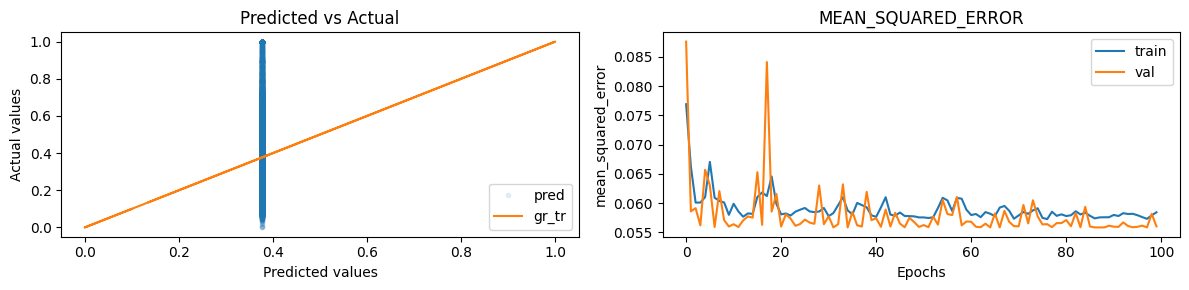

{'LOSS': 0.05841577425599098, 'MEAN_SQUARED_ERROR': 0.05841577425599098, 'VAL_LOSS': 0.05600981414318085, 'VAL_MEAN_SQUARED_ERROR': 0.05600981414318085}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  1
484/484 [==============================] - 1s 1ms/step


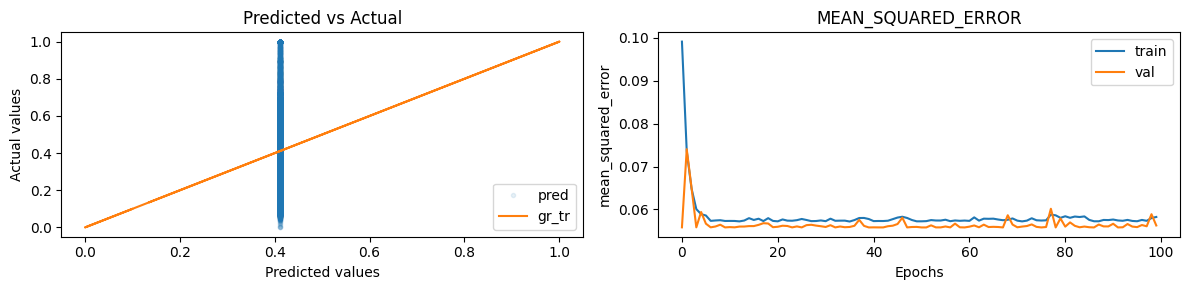

{'LOSS': 0.05825907364487648, 'MEAN_SQUARED_ERROR': 0.05825907364487648, 'VAL_LOSS': 0.056280430406332016, 'VAL_MEAN_SQUARED_ERROR': 0.056280430406332016}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


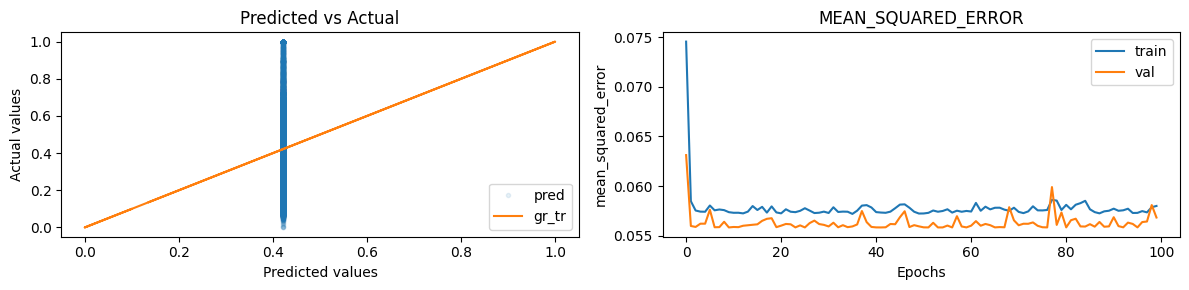

{'LOSS': 0.05798924341797829, 'MEAN_SQUARED_ERROR': 0.05798924341797829, 'VAL_LOSS': 0.05682303383946419, 'VAL_MEAN_SQUARED_ERROR': 0.05682303383946419}
INITIAL LEARNING RATE:  0.01
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


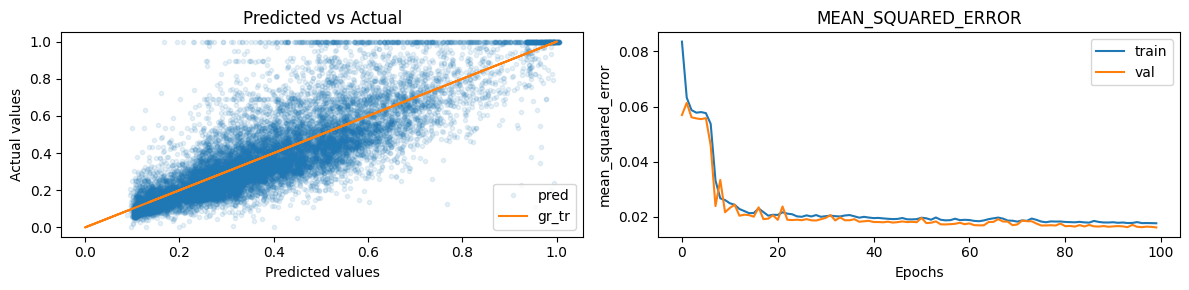

{'LOSS': 0.017655309289693832, 'MEAN_SQUARED_ERROR': 0.017655309289693832, 'VAL_LOSS': 0.01614443026483059, 'VAL_MEAN_SQUARED_ERROR': 0.01614443026483059}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  1
484/484 [==============================] - 1s 2ms/step


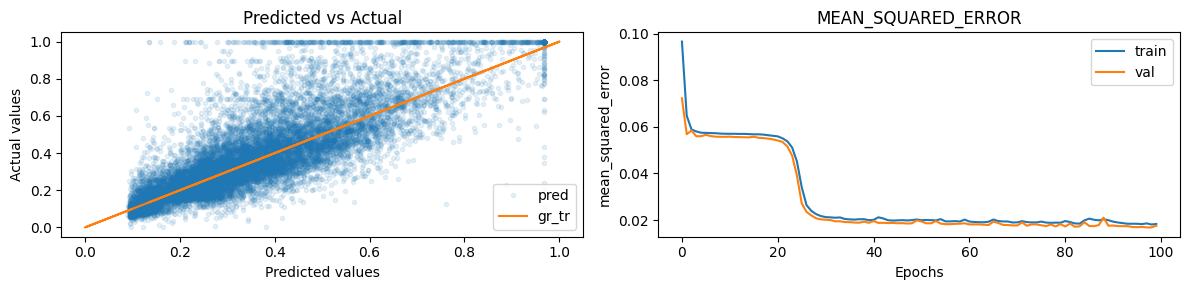

{'LOSS': 0.0183474849909544, 'MEAN_SQUARED_ERROR': 0.0183474849909544, 'VAL_LOSS': 0.017599739134311676, 'VAL_MEAN_SQUARED_ERROR': 0.017599739134311676}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.96
484/484 [==============================] - 1s 1ms/step


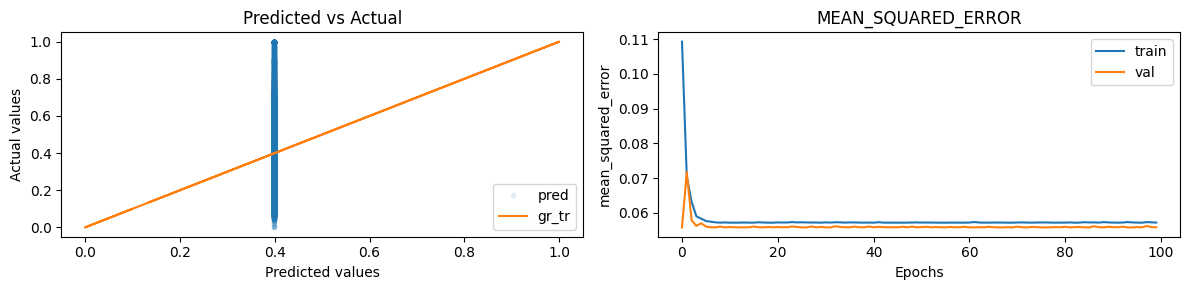

{'LOSS': 0.057207487523555756, 'MEAN_SQUARED_ERROR': 0.057207487523555756, 'VAL_LOSS': 0.05586674064397812, 'VAL_MEAN_SQUARED_ERROR': 0.05586674064397812}
INITIAL LEARNING RATE:  0.001
DECAY RATE:  0.1
484/484 [==============================] - 1s 1ms/step


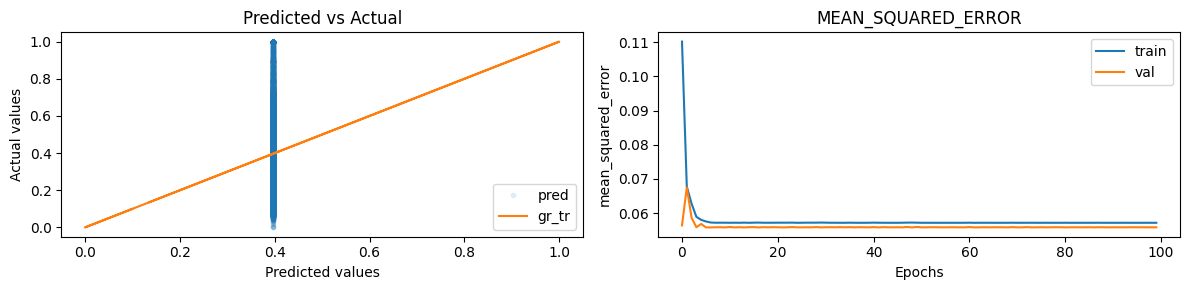

{'LOSS': 0.05717959627509117, 'MEAN_SQUARED_ERROR': 0.05717959627509117, 'VAL_LOSS': 0.05585601553320885, 'VAL_MEAN_SQUARED_ERROR': 0.05585601553320885}


In [58]:
evaluate_optimizer_and_learning_rate(initial_learning_rates, decay_rates, 'SGDM_Large', 100, [x_train_n, y_train_n], 'sgd_large_learning_rate_table')

In [63]:
import json

def print_latex_table_from_json(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)

    header = "Initial Learning Rate & Decay Rate & LOSS & VAL LOSS  \\\\"
    table_rows = []

    for initial_lr, decay_rates in data.items():
        for decay_rate, metrics in decay_rates.items():
            row = f"{initial_lr} & {decay_rate} & {metrics['LOSS']:.5f} & {metrics['VAL_LOSS']:.5f}  \\\\"
            table_rows.append(row)

    print("\\begin{table}[h]")
    print("\\centering")
    print("\\begin{tabular}{|c|c|c|c|}")
    print("\\hline")
    print(header)
    print("\\hline")
    for row in table_rows:
        print(row)
    print("\\hline")
    print("\\end{tabular}")
    print("\\caption{Your Caption Here}")
    print("\\label{tab:my_label}")
    print("\\end{table}")

# Replace 'file_name.json' with your JSON file's name



In [64]:
print_latex_table_from_json('adam_learning_rate_table.json')

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Initial Learning Rate & Decay Rate & LOSS & VAL LOSS  \\
\hline
0.1 & 1 & 0.05854 & 0.05742  \\
0.1 & 0.96 & 0.05720 & 0.05592  \\
0.1 & 0.1 & 0.05719 & 0.05591  \\
0.01 & 1 & 0.01413 & 0.01443  \\
0.01 & 0.96 & 0.01394 & 0.01322  \\
0.01 & 0.1 & 0.01116 & 0.01150  \\
0.001 & 1 & 0.01235 & 0.01115  \\
0.001 & 0.96 & 0.01196 & 0.01184  \\
0.001 & 0.1 & 0.01280 & 0.01246  \\
\hline
\end{tabular}
\caption{Your Caption Here}
\label{tab:my_label}
\end{table}


In [65]:
print_latex_table_from_json('sgd_learning_rate_table.json')

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Initial Learning Rate & Decay Rate & LOSS & VAL LOSS  \\
\hline
0.1 & 1 & 0.01973 & 0.01827  \\
0.1 & 0.96 & 0.05721 & 0.05583  \\
0.1 & 0.1 & 0.05718 & 0.05588  \\
0.01 & 1 & 0.01958 & 0.01816  \\
0.01 & 0.96 & 0.02052 & 0.01936  \\
0.01 & 0.1 & 0.02114 & 0.02001  \\
0.001 & 1 & 0.05042 & 0.04908  \\
0.001 & 0.96 & 0.02857 & 0.02717  \\
0.001 & 0.1 & 0.05708 & 0.05576  \\
\hline
\end{tabular}
\caption{Your Caption Here}
\label{tab:my_label}
\end{table}


In [66]:
print_latex_table_from_json('sgd_small_learning_rate_table.json')

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Initial Learning Rate & Decay Rate & LOSS & VAL LOSS  \\
\hline
0.1 & 1 & 0.05804 & 0.05583  \\
0.1 & 0.96 & 0.05797 & 0.05584  \\
0.1 & 0.1 & 0.05724 & 0.05595  \\
0.01 & 1 & 0.01848 & 0.01791  \\
0.01 & 0.96 & 0.01840 & 0.01725  \\
0.01 & 0.1 & 0.01851 & 0.01708  \\
0.001 & 1 & 0.01926 & 0.01776  \\
0.001 & 0.96 & 0.05718 & 0.05588  \\
0.001 & 0.1 & 0.02209 & 0.02091  \\
\hline
\end{tabular}
\caption{Your Caption Here}
\label{tab:my_label}
\end{table}


In [67]:
print_latex_table_from_json('sgd_large_learning_rate_table.json')

\begin{table}[h]
\centering
\begin{tabular}{|c|c|c|c|}
\hline
Initial Learning Rate & Decay Rate & LOSS & VAL LOSS  \\
\hline
0.1 & 1 & 0.06172 & 0.05865  \\
0.1 & 0.96 & 0.05920 & 0.05924  \\
0.1 & 0.1 & 0.05842 & 0.05601  \\
0.01 & 1 & 0.05826 & 0.05628  \\
0.01 & 0.96 & 0.05799 & 0.05682  \\
0.01 & 0.1 & 0.01766 & 0.01614  \\
0.001 & 1 & 0.01835 & 0.01760  \\
0.001 & 0.96 & 0.05721 & 0.05587  \\
0.001 & 0.1 & 0.05718 & 0.05586  \\
\hline
\end{tabular}
\caption{Your Caption Here}
\label{tab:my_label}
\end{table}
